# Explore Text

In [360]:
import os
import json
import string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import pandas as pd
import re
pd.options.mode.chained_assignment = None  # default='warn'

In [361]:
df_ori = pd.read_csv('../data/data job posts.csv')
df_ori.head()
print(df_ori.shape)
df = df_ori.drop_duplicates(['jobpost','Title'])
print(df.shape)
print("Removed {0} duplicates (based on jobpost + Title)".format(df_ori.shape[0]-df.shape[0]))

(19001, 24)
(18892, 24)
Removed 109 duplicates (based on jobpost + Title)


In [364]:
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))  # remove emails
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub('\s+', ' ', x))  # remove newlines
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub("\'", "", x))  # remove single quotes
re1 = '(www)'  # Word 1
re2 = '(\\.)'  # Any Single Character 1
re3 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 1
re4 = '(\\.)'  # Any Single Character 2
re5 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 2
rg = re.compile(re1 + re2 + re3 + re4 + re5, re.IGNORECASE | re.DOTALL)
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub(rg, "", x))
re1 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 1
re2 = '(\\.)'  # Any Single Character 1
re3 = '((?:[a-z][a-z0-9_]*))'  # Word 1
rg = re.compile(re1 + re2 + re3, re.IGNORECASE | re.DOTALL)
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub(rg, "", x))
df.jobpost = df.jobpost.apply(lambda x: re.sub('(\\d+)', "", x))  # remove numbers

In [365]:
df['jobpost_token'] = df.jobpost.map(word_tokenize)

In [366]:
df.jobpost_token.head()

0    [AMERIA, Investment, Consulting, Company, JOB,...
1    [International, Research, &, Exchanges, Board,...
2    [Caucasus, Environmental, NGO, Network, (, CEN...
3    [Manoff, Group, JOB, TITLE, :, BCC, Specialist...
4    [Yerevan, Brandy, Company, JOB, TITLE, :, Soft...
Name: jobpost_token, dtype: object

In [367]:
#df.jobpost_token[0]


In [375]:
df['jobpost_len'] = df.jobpost_token.apply(len)

In [376]:
df.jobpost_len.head()

0    988
1    435
2    352
3    680
4    248
Name: jobpost_len, dtype: int64

Text(0.5,1,'Length of jobpost (for each of the rows), plotted')

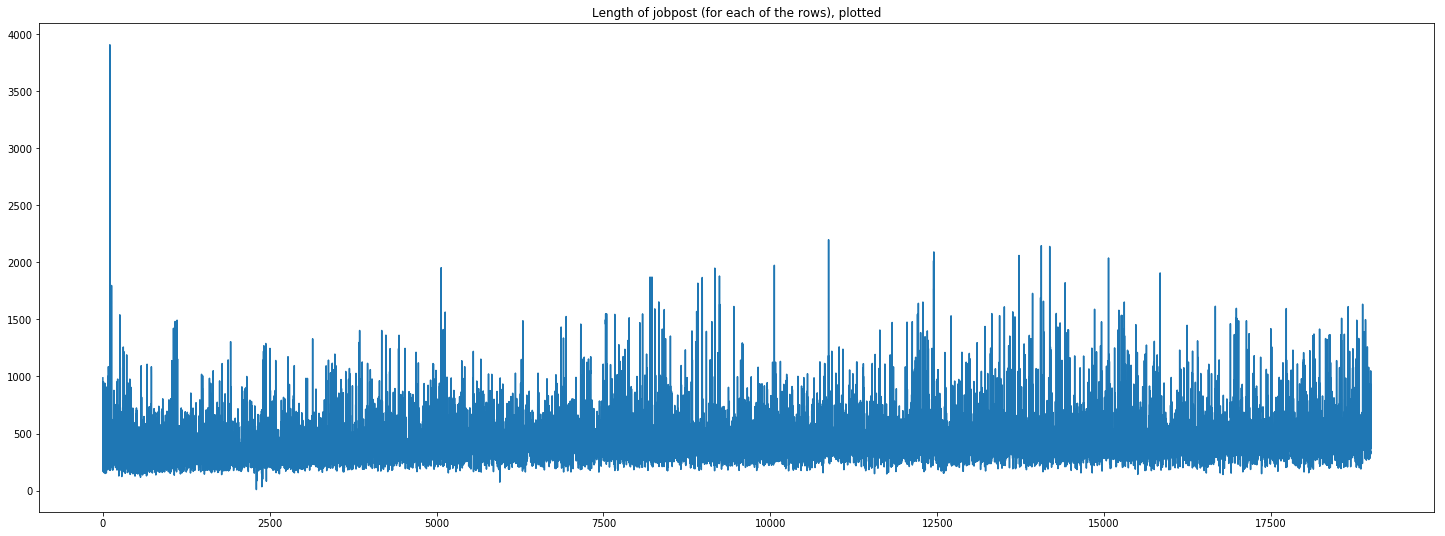

In [377]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 9))
plt.plot(df.jobpost_len)
plt.title('Length of jobpost (for each of the rows), plotted')

In [378]:
df['jobpost_token_uniq'] = df.jobpost_token.apply(set)

In [1]:
df['jobpost_token_uniq']

NameError: name 'df' is not defined

Text(0.5,1,'Length of jobpost unique tokens (for each of the rows), plotted')

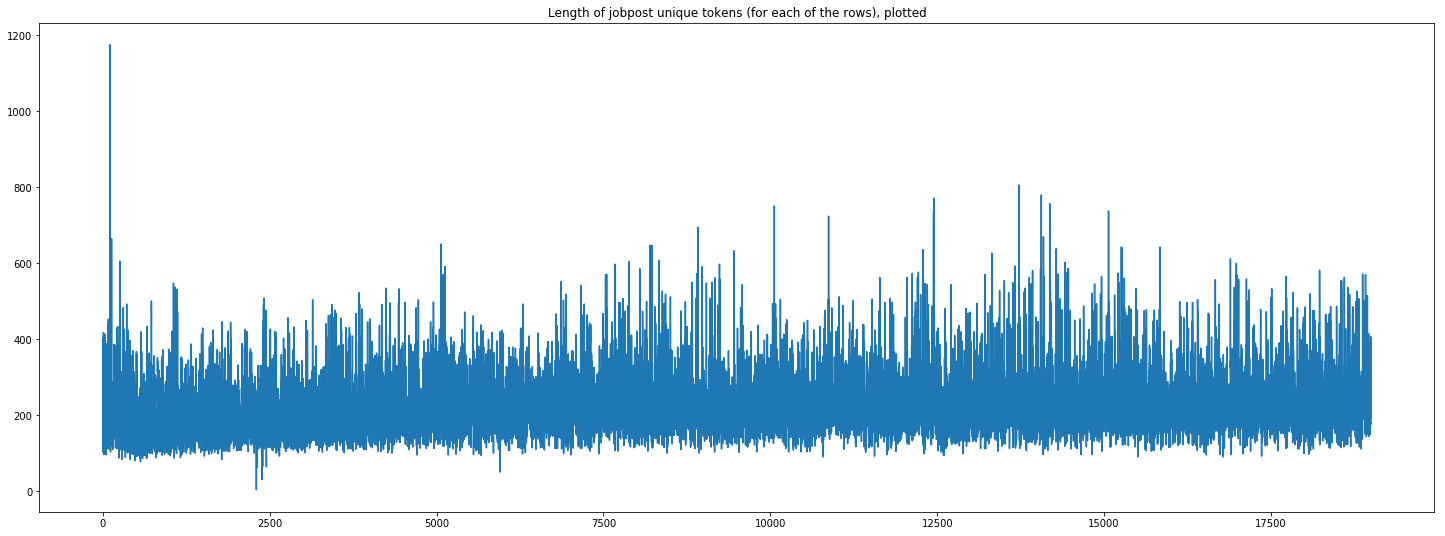

In [380]:
plt.figure(figsize=(25, 9))
plt.plot(df.jobpost_token_uniq.apply(len))
plt.title('Length of jobpost unique tokens (for each of the rows), plotted')

Text(0.5,1,'Avg. no. times each word is used (for each of the rows), plotted')

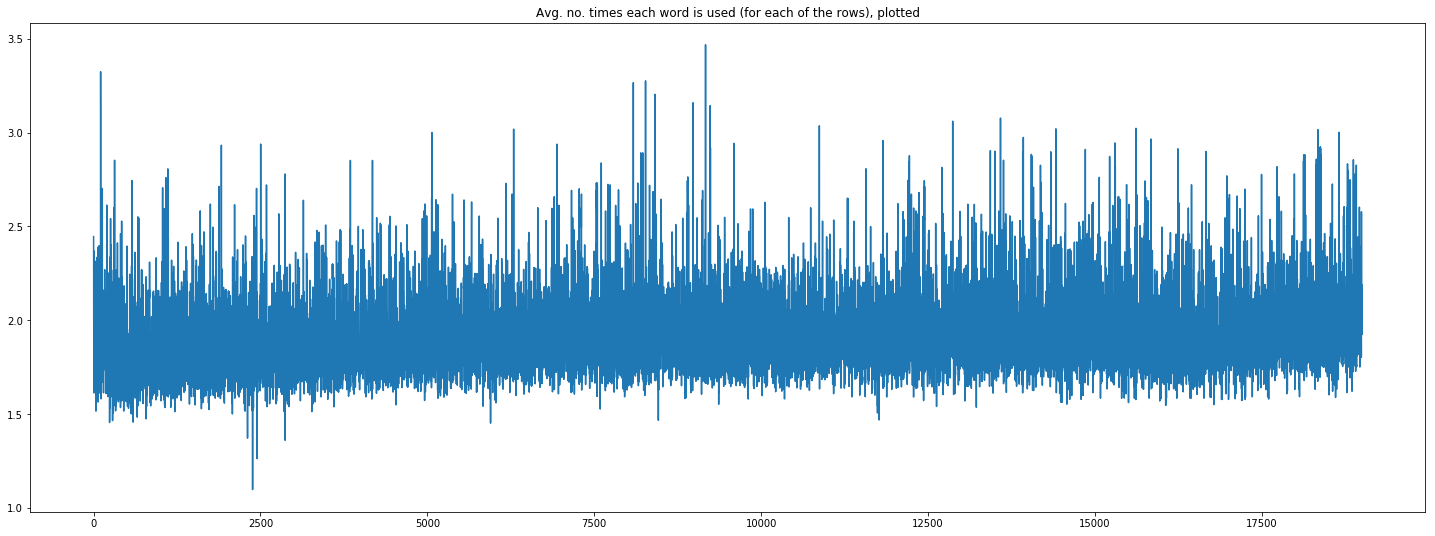

In [381]:
plt.figure(figsize=(25, 9))
plt.plot(df['jobpost_len']/df.jobpost_token_uniq.apply(len))
plt.title('Avg. no. times each word is used (for each of the rows), plotted')

So on average, each word is used 1.5 - 2.5 times in each job posting. 

## Try One Row First, if it works we can make it into a function and apply across the rows

In [382]:
tokens = (df.iloc[0])['jobpost_token']

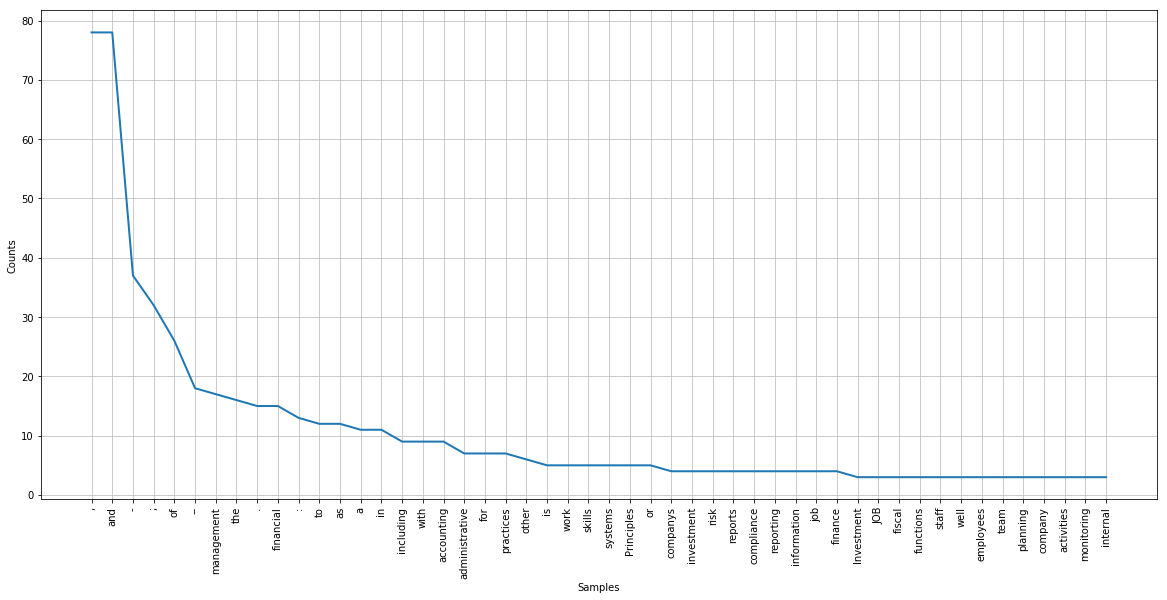

In [383]:
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens)  # case sensitive!
fd.most_common(50)
fd.plot(50)

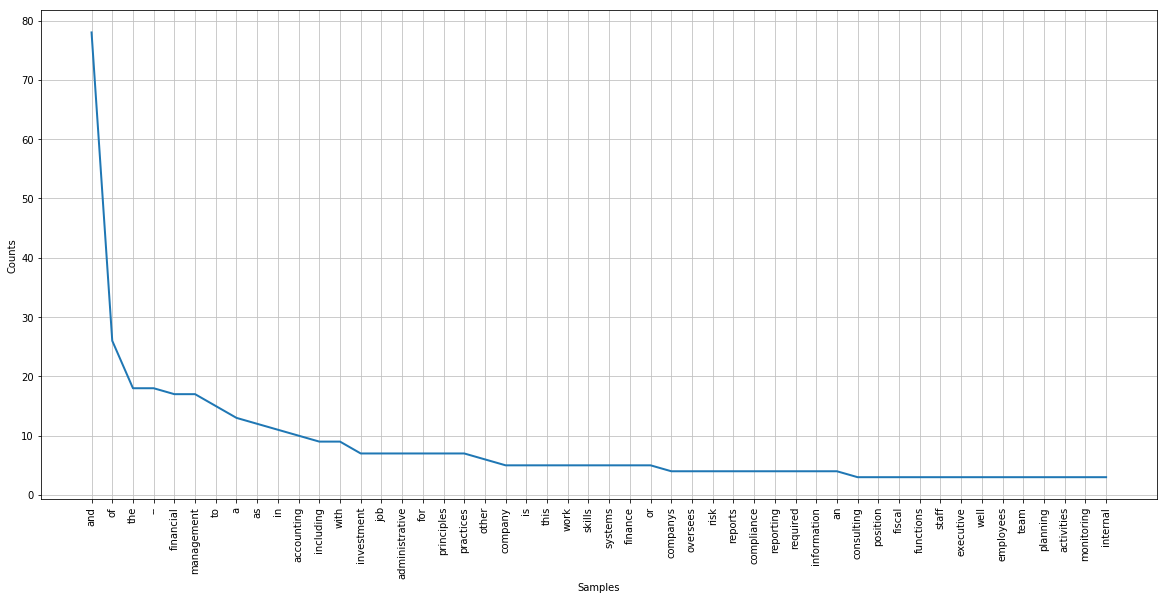

In [384]:
# Remove punctuations, convert all to lower-case, and try again
tokens_nop = [t for t in tokens if t not in string.punctuation]
tokens_nop = [t.lower() for t in tokens_nop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_nop)  # case sensitive!
fd.most_common(50)
fd.plot(50)

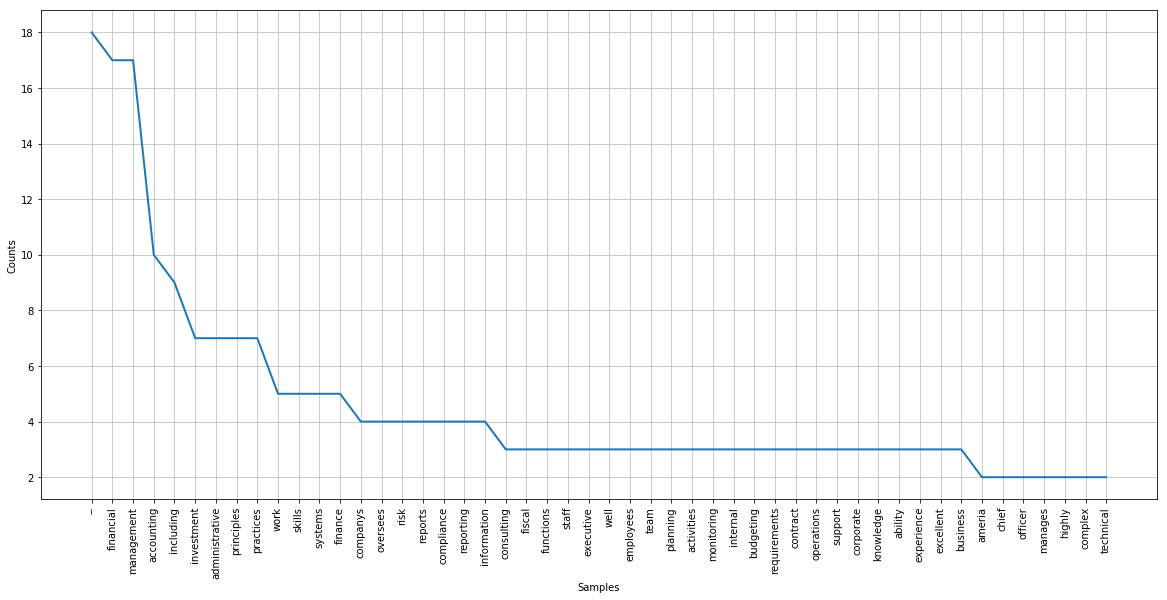

In [385]:
# Remove stopwords, and try again
stop = stopwords.words('english')
stop.extend(['armenian','armenia', 'job', 'title', 'position', 'location', 'responsibilities', 'application', 'procedures',
                 'deadline', 'required', 'qualifications', 'renumeration', 'salary', 'date', 'company','llc'])
tokens_nostop = [t for t in tokens_nop if t not in stop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_nostop)  # case sensitive!
fd.most_common(50)
fd.plot(50)

Tokens starting to have some meaning. What can we do with this? 
Job title is : 

In [386]:
print((df.iloc[0])['Title'])

Chief Financial Officer


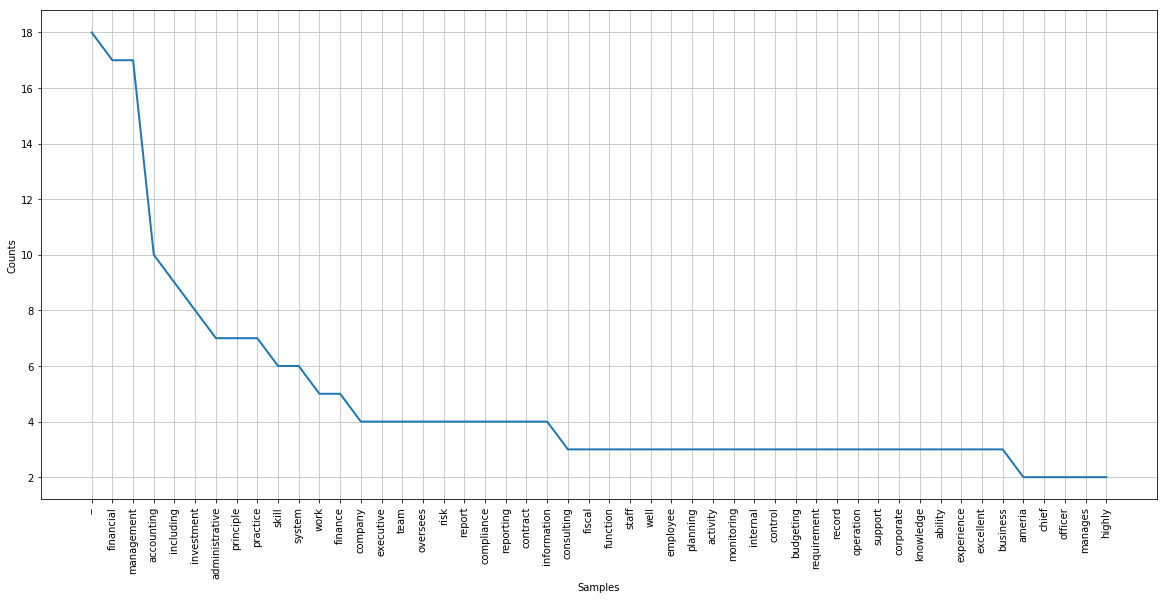

In [387]:
wnl = nltk.WordNetLemmatizer()
tokens_lem = [wnl.lemmatize(t) for t in tokens_nostop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_lem)  # case sensitive!
fd.most_common(50)
fd.plot(50)

We see terms like executive and team after WordNet Lemmatizer. Seems to have a positive effect. Also, previous words like "investment", "skill", "system" have been "strengthened".

In [388]:
tokens_clean = [t for t in tokens_lem if len(t) >= 3]  # simple way to remove the offending " punctuations
text_clean = " ".join(tokens_clean)


In [408]:
#print(text_clean)
bigram = gensim.models.Phrases(tokens_clean, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(tokens_clean, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[tokens_clean]])

['yerevan', 'brandy', 'software', 'developer', 'yerevan', 'rendering', 'technical', 'assistance', 'database', 'management', 'system', 'realization', 'sql', 'server', 'maintenance', 'activity', 'back-up', 'replication', 'participation', 'designing', 'software', 'development', 'project', 'university', 'degree', 'economical', 'background', 'plus', 'excellent', 'knowledge', 'window', 'server', 'networking', 'tcp/', 'technology', 'sql', 'server', 'visual', 'basic', 'least', 'year', 'experience', 'database', 'software', 'development', 'good', 'knowledge', 'english', 'remuneration', 'commensurate', 'norm', 'accepted', 'successful', 'candidate', 'submit', 'relevant', 'recommendation', 'letter', 'previous', 'employer', 'copy', '-ies', 'diploma', 'relevant', 'certificate', 'available', 'color', 'photo', 'either', 'isakov', 'avenue', 'yerevan', 'send', 'following', 'fax', 'e-mail', 'human', 'resource', 'department', 'armine', 'bibilyan', 'please', 'clearly', 'mention', 'letter', 'learned', 'oppor

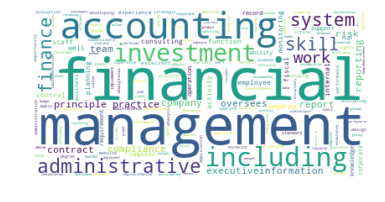

In [390]:
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

wc = WordCloud(background_color="white").generate(text_clean)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Create a Preprocessing Function for All Rows

In [391]:
def preprocess(tokens):
    tokens_nop = [t for t in tokens if t not in string.punctuation]
    tokens_nop = [t.lower() for t in tokens_nop]
    wnl = nltk.WordNetLemmatizer()
    stop = stopwords.words('english')
    stop.extend(['armenian','armenia', 'job', 'title', 'position', 'location', 'responsibilities', 'application', 'procedures',
                 'deadline', 'required', 'qualifications', 'renumeration', 'salary', 'date', 'company'])
    tokens_nostop = [t for t in tokens_nop if t not in stop]
    tokens_lem = [wnl.lemmatize(t) for t in tokens_nostop]
    tokens_clean = [t for t in tokens_lem if len(t) >= 3]  # simple way to remove the offending " punctuations
    return tokens_clean

def plotWC(tokens):
    text_clean = " ".join(tokens)
    print(text_clean)
    wc = WordCloud(background_color="white").generate(text_clean)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(20, 9))
    fd = nltk.FreqDist(tokens)  # case sensitive!
    fd.plot(50)

In [392]:
tokens_clean = preprocess((df.iloc[4])['jobpost_token']) # we know this is a software job
print(tokens_clean)

['yerevan', 'brandy', 'software', 'developer', 'yerevan', 'rendering', 'technical', 'assistance', 'database', 'management', 'system', 'realization', 'sql', 'server', 'maintenance', 'activity', 'back-up', 'replication', 'participation', 'designing', 'software', 'development', 'project', 'university', 'degree', 'economical', 'background', 'plus', 'excellent', 'knowledge', 'window', 'server', 'networking', 'tcp/', 'technology', 'sql', 'server', 'visual', 'basic', 'least', 'year', 'experience', 'database', 'software', 'development', 'good', 'knowledge', 'english', 'remuneration', 'commensurate', 'norm', 'accepted', 'successful', 'candidate', 'submit', 'relevant', 'recommendation', 'letter', 'previous', 'employer', 'copy', '-ies', 'diploma', 'relevant', 'certificate', 'available', 'color', 'photo', 'either', 'isakov', 'avenue', 'yerevan', 'send', 'following', 'fax', 'e-mail', 'human', 'resource', 'department', 'armine', 'bibilyan', 'please', 'clearly', 'mention', 'letter', 'learned', 'oppor

yerevan brandy software developer yerevan rendering technical assistance database management system realization sql server maintenance activity back-up replication participation designing software development project university degree economical background plus excellent knowledge window server networking tcp/ technology sql server visual basic least year experience database software development good knowledge english remuneration commensurate norm accepted successful candidate submit relevant recommendation letter previous employer copy -ies diploma relevant certificate available color photo either isakov avenue yerevan send following fax e-mail human resource department armine bibilyan please clearly mention letter learned opportunity career center mention url website thanks january place free posting career related opportunity organization website e-mail


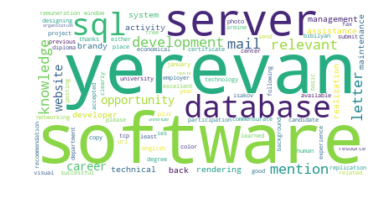

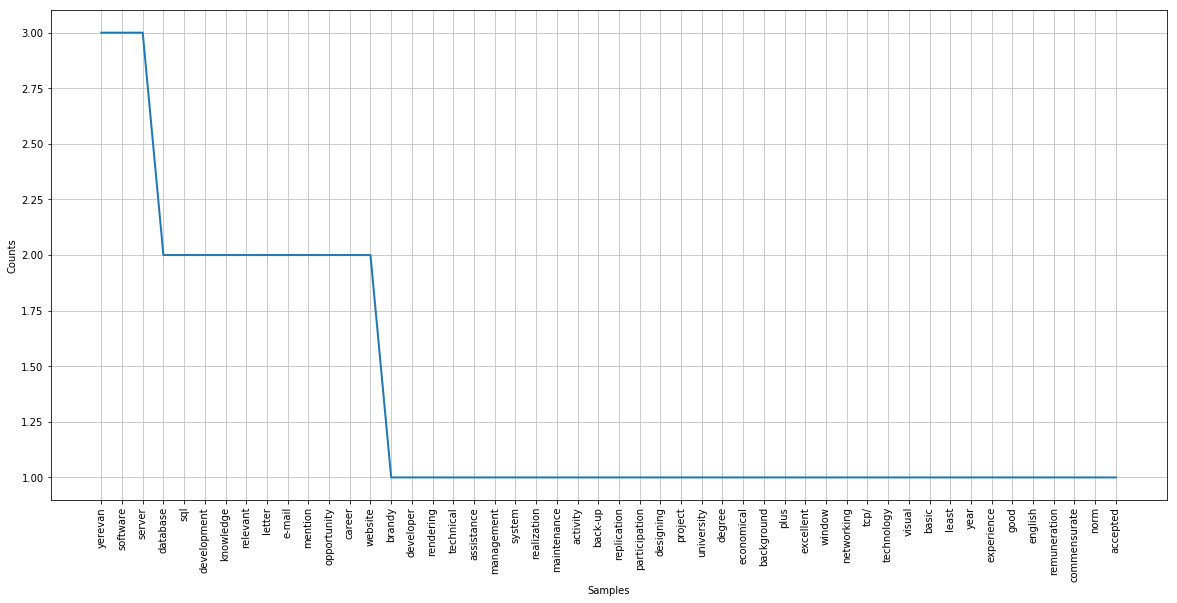

In [393]:
plotWC(tokens_clean)

In [394]:
df['jobpost_processed'] = df.jobpost_token.apply(preprocess)

In [395]:
bigram = gensim.models.Phrases(df['jobpost_processed'], min_count=5, threshold=110)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['jobpost_processed']], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

df.jobpost_processed = make_bigrams(df.jobpost_processed)

/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Get Feature Matrix

In [430]:
print(df.jobpost_processed[8])

['yerevan', 'brandy', 'assistant', 'managing', 'director', 'yerevan', 'coordinating', 'work', 'subordinate', 'employee', 'maintaining', 'liaison', 'subdivision', 'within', 'managing', 'correspondence', 'flow', 'realizing', 'written', 'verbal', 'translation', 'organizing', 'meeting', 'conference', 'compiling', 'minute', 'meeting', 'drawing', 'report', 'operating', 'office', 'equipment', 'university', 'degree', 'least', 'year', 'experience', 'relevant', 'field', 'mastership', 'office', 'work', 'competency', 'business', 'ethic', 'excellent', 'working', 'knowledge', 'written', 'verbal', 'russian', 'english', 'knowledge', 'french', 'plus', 'knowledge', 'office', 'strong', 'problem-solving', 'organizational', 'skill', 'outstanding', 'interpersonal', 'skill', 'remuneration', 'commensurate', 'norm', 'accepted', 'successful', 'candidate', 'submit', 'relevant', 'recommendation', 'letter', 'previous', 'employer', 'copy', '-ies_diploma', 'color_photo', 'either_isakov', 'avenue', 'yerevan', 'send',

In [431]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    
df['jobpost_processedtext'] = df.jobpost_processed.apply(lambda x: ' '.join(x))

In [432]:
vec_tf = CountVectorizer()
grain_tf = vec_tf.fit_transform(df['jobpost_processedtext'])
print(grain_tf.shape)

vec_tf = CountVectorizer(min_df=2)
grain_tf = vec_tf.fit_transform(df['jobpost_processedtext'])
print(grain_tf.shape)


(18892, 27869)
(18892, 19761)


In [433]:
vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
grain_tfidf = vec_tfidf.fit_transform(df['jobpost_processedtext'])
print(grain_tfidf.shape)

(18892, 16578)


In [434]:
 # To save the vectorized results for future use
import pickle

pickle.dump(grain_tfidf, open("tfidf.pkl", "wb"))
pickle.dump(vec_tfidf.vocabulary_, open("feature.pkl", "wb"))


In [435]:
# load the content
# loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=pickle.load(open("feature.pkl", "rb")))
# tfidf = pickle.load(open("./tfidf.pkl", "rb"))
# print(tfidf)
print(grain_tfidf)

  (0, 931)	0.09257240318593889
  (0, 8132)	0.24643126768531132
  (0, 3550)	0.08660172857446048
  (0, 2785)	0.06383247610957593
  (0, 6056)	0.3151275309181904
  (0, 10441)	0.054635144363314764
  (0, 13372)	0.02066776297201763
  (0, 9184)	0.09660833734779409
  (0, 3214)	0.07768287674598456
  (0, 6097)	0.13448596255828912
  (0, 560)	0.16875228494621766
  (0, 6460)	0.08179539556365716
  (0, 11966)	0.028231571610352144
  (0, 7171)	0.038611002605881954
  (0, 12818)	0.014075365178876996
  (0, 14804)	0.04583952939129426
  (0, 3282)	0.054740776856587625
  (0, 14094)	0.05809461530420435
  (0, 1478)	0.02478025625191826
  (0, 5665)	0.11941669381232868
  (0, 4575)	0.04963529192982974
  (0, 11080)	0.037673253593176886
  (0, 12726)	0.037673253593176886
  (0, 7164)	0.03609819005154246
  (0, 8793)	0.037705141470394415
  :	:
  (18891, 7676)	0.08878557173050607
  (18891, 3546)	0.06607823722338887
  (18891, 10925)	0.06552787820288179
  (18891, 7645)	0.06701600528564698
  (18891, 4144)	0.043164875057228214

## Overall Clustering 

In [461]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Use SVD to reduce dimensions
svd = TruncatedSVD(2000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(grain_tfidf)

In [462]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 82%


In [463]:
from sklearn.cluster import KMeans
from sklearn import metrics
num_clusters = 4

for num in [num_clusters]:
    km3 = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    %time km3.fit(X_lsa)
    # The higher the better (-1 to 1)
    print("Clusters: {0}".format(num))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))

CPU times: user 6.67 s, sys: 694 ms, total: 7.37 s
Wall time: 6.57 s
Clusters: 4
Silhouette Coefficient for clusters: 0.018


In [464]:
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vec_tfidf.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind], end='')
        print()

print_terms(km3, num_clusters)


Cluster 0: sale customer marketing russian excellent ability llc service term manager office responsible good product business communication mail information system interested
Cluster 1: project program development management international training community implementation activity support office programme public staff national government ability child local ensure
Cluster 2: accounting bank financial credit finance banking tax cjsc report loan prepare accountant management legislation internal audit branch control risk business
Cluster 3: software development developer design web test team testing java good engineer application technology ability technical system programming project net term


Cluster 0: Sales and Marketing Jobs (communication-based, requiring russian speaking ability) 

Cluster 1: Project/Program Management and Development 

Cluster 2: Financial related jobs (Accounting, Banking) 

Cluster 3: Software Developers and Web Design 


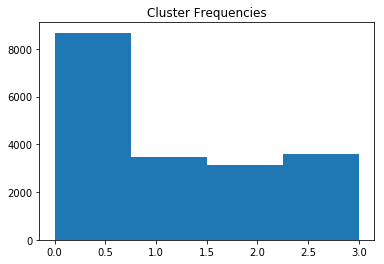

In [465]:
plt.hist(km3.labels_, bins=num_clusters)
plt.title('Cluster Frequencies')
plt.show()

Any pattern here between the clusters? 

## See How the Clustering Changes Through-out the Years

In [466]:
df_04to07 = df[df.Year <= 2007]
df_08to11 = df[df.Year <= 2011]
df_12to15 = df[df.Year <= 2015]


## 2004 - 2007

In [475]:
# refactor it to a function
def clusterdf(df_in, num):
    vec_tf = CountVectorizer()
    grain_tf = vec_tf.fit_transform(df_in['jobpost_processedtext'])
    vec_tf = CountVectorizer(min_df=2)
    grain_tf = vec_tf.fit_transform(df_in['jobpost_processedtext'])
    vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
    grain_tfidf = vec_tfidf.fit_transform(df_in['jobpost_processedtext'])
    # Use SVD to reduce dimensions
    svd = TruncatedSVD(2000)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X_lsa = lsa.fit_transform(grain_tfidf)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    km3 = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    %time km3.fit(X_lsa)
    # The higher the better (-1 to 1)
    print("Clusters: {0}".format(num))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))
    print_terms(km3, num)
    plt.hist(km3.labels_, bins=num)
    plt.title('Cluster Frequencies')
    plt.show()

Explained variance of the SVD step: 95%
CPU times: user 1.71 s, sys: 49.4 ms, total: 1.76 s
Wall time: 929 ms
Clusters: 4
Silhouette Coefficient for clusters: 0.016
Cluster 0: accounting financial bank software tax finance accountant report cjsc good credit prepare ability term chief_accountant development design excellent legislation office
Cluster 1: software development design developer web team test ability technical technology product good system application java llc testing engineer term database
Cluster 2: project development management program ability financial activity system support office international implementation community business ensure legal training team report provide
Cluster 3: sale customer marketing bank service manager product credit market business russian excellent office cjsc responsible client communication management llc good


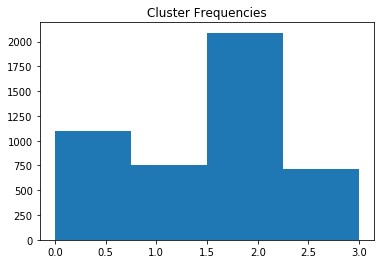

In [476]:
clusterdf(df_04to07, num_clusters)


Cluster 3: Sales and Marketing Jobs (communication-based, requiring russian speaking ability)

Cluster 2: Project/Program Management and Development

Cluster 0: Financial related jobs (Accounting, Banking)

Cluster 1: Software Developers and Web Design

We see that most of the jobs required are project management and development. 
This is followed by financial related jobs like accounting and banking. 

## 2008 to 2011

Explained variance of the SVD step: 87%
CPU times: user 3.27 s, sys: 302 ms, total: 3.58 s
Wall time: 2.45 s
Clusters: 4
Silhouette Coefficient for clusters: 0.014
Cluster 0: sale customer marketing manager russian excellent market llc product service office communication ability open responsible business administrative company call term
Cluster 1: accounting financial software bank tax good finance accountant system legal cjsc report ability term prepare excellent developer llc legislation office
Cluster 2: software development design developer web team test product ability technical good testing llc java engineer service technology term project customer
Cluster 3: project development financial management bank marketing business accounting program ability report system activity software service ensure implementation credit team develop


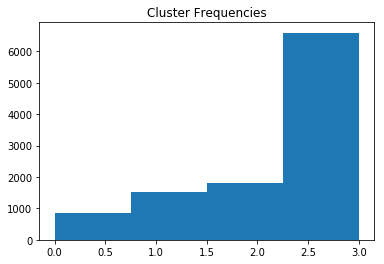

In [477]:
clusterdf(df_08to11, num_clusters)


Cluster 0: Sales and Marketing Jobs (communication-based, requiring russian speaking ability)

Cluster 3: Project/Program Management and Development

Cluster 1: Financial related jobs (Accounting, Banking)

Cluster 2: Software Developers and Web Design

We see that most of the jobs required are still project management and development. 
There is less demand for sales and marketing customer-centric jobs during these years. 

## 2012 to 2015

Explained variance of the SVD step: 82%
CPU times: user 4.27 s, sys: 497 ms, total: 4.77 s
Wall time: 3.32 s
Clusters: 4
Silhouette Coefficient for clusters: 0.016
Cluster 0: accounting financial tax accountant finance report chief_accountant prepare audit bank account control legislation reporting cash internal management standard statement payment
Cluster 1: sale marketing customer product market service manager business client llc excellent ability russian develop brand strategy communication plan new responsible
Cluster 2: software development design developer web test team testing java good engineer application technology ability technical system project programming net term
Cluster 3: project bank office ability management excellent program development russian service information system good term international responsible activity business communication relevant


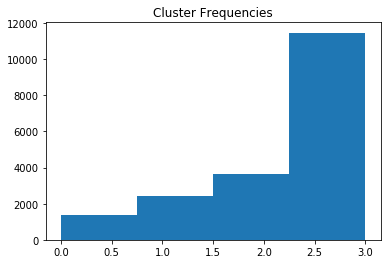

In [478]:
clusterdf(df_12to15, num_clusters)


Cluster 1: Sales and Marketing Jobs (communication-based, requiring russian speaking ability)

Cluster 3: Project/Program Management and Development

Cluster 0: Financial related jobs (Accounting, Banking)

Cluster 2: Software Developers and Web Design

We see that most of the jobs required are still project management and development. 
There is significantly less demand for financial accounting and banking jobs in these years. 
Overall, we can see that sales and marketing jobs as well as financial accounting related jobs have gone down over the years. 
Software development jobs have been relatively constant throughout the years, proportion-wise.  
Russian keeps popping up, on some investigation, knowing how to speak russian is important apparently. 